# **Постановка задачи и данные**

Цель задачи — **бинарная классификация**: определить, является ли человек **здоровым** по результатам ЭКГ.  
Целевая переменная — **Healthy**:  
- `1` — здоров  
- `0` — потенциально аномальный

## **Данные**

Входной датасет — табличные данные с признаками, извлечёнными из сигналов ЭКГ. В него входят:

- `rr_interval` — RR интервал (мс)
- `p_onset` — начало P-волны (мс)
- `p_end` — конец P-волны (мс)
- `qrs_onset` — начало QRS-комплекса (мс)
- `qrs_end` — конец QRS-комплекса (мс)
- `t_end` — конец T-волны (мс)
- `p_axis` — ось P (°)
- `qrs_axis` — ось QRS (°)
- `t_axis` — ось T (°)
- `Healthy` — целевая переменная (0 или 1)

# **Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# **Загрузка и первичный осмотр данных**

In [10]:
df = pd.read_csv("ecg_data.csv")

print("Размер датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)

Размер датасета: (300, 10)

Типы данных:
Healthy        int64
rr_interval    int64
p_onset        int64
p_end          int64
qrs_onset      int64
qrs_end        int64
t_end          int64
p_axis         int64
qrs_axis       int64
t_axis         int64
dtype: object


In [9]:
df.isnull().sum()

Healthy        0
rr_interval    0
p_onset        0
p_end          0
qrs_onset      0
qrs_end        0
t_end          0
p_axis         0
qrs_axis       0
t_axis         0
dtype: int64

In [6]:
df.head()

,Healthy,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,0,845,40,158,194,280,592,61,38,18
1,1,1052,40,154,180,286,628,47,3,-25
2,1,857,29999,29999,200,354,662,29999,-70,95
3,0,750,40,154,190,286,554,61,58,58
4,1,723,323,29999,504,600,915,35,-16,48


In [14]:
df["Healthy"].value_counts(normalize=True)

Healthy
1    0.806667
0    0.193333
Name: proportion, dtype: float64

# **Разведочный анализ**

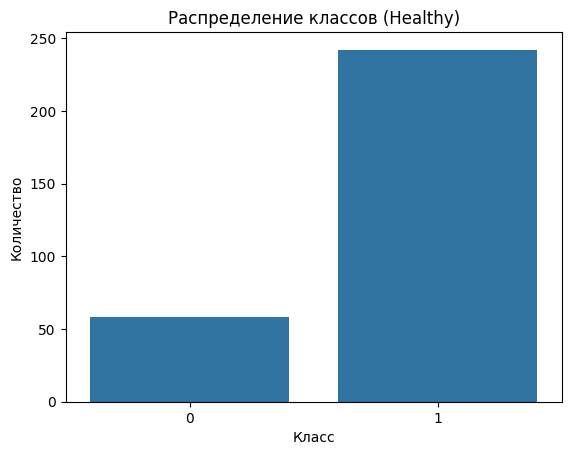

In [15]:
sns.countplot(x="Healthy", data=df)
plt.title("Распределение классов (Healthy)")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

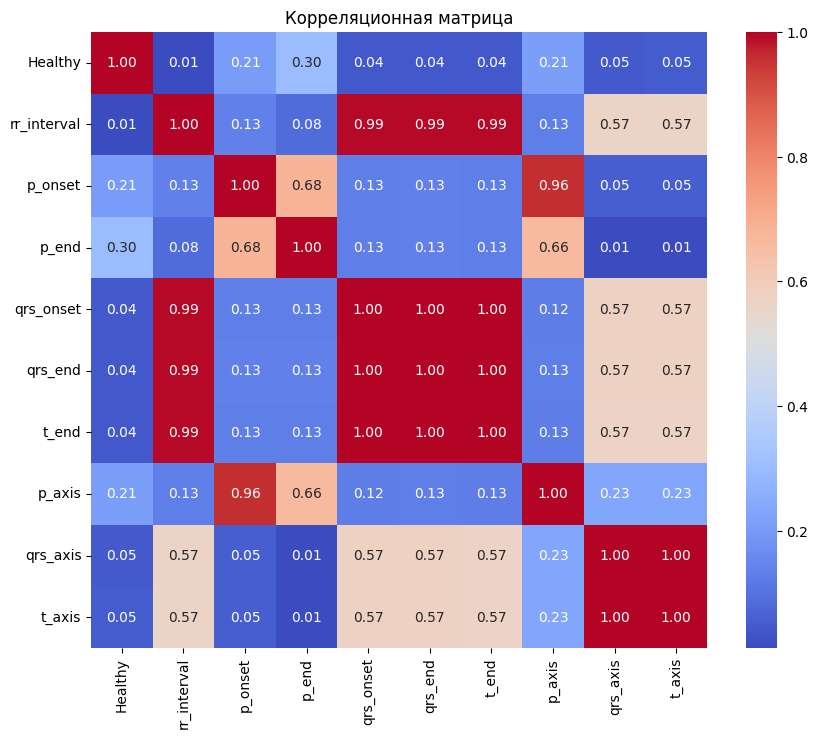

In [16]:
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица")
plt.show()

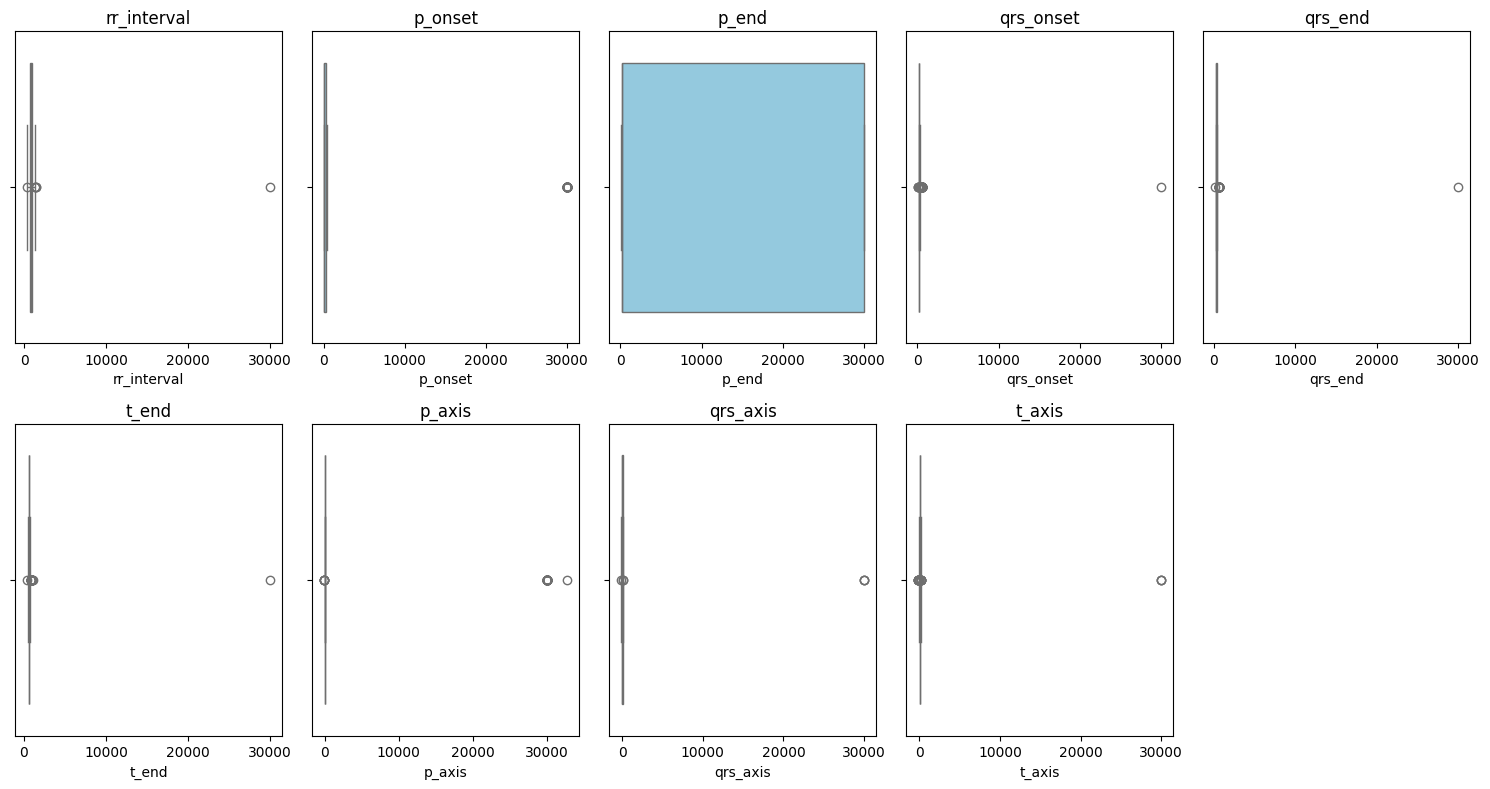

In [18]:
numeric_features = df.select_dtypes(include=["float64", "int64"]).drop(columns=["Healthy"])

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_features.columns, 1):
    plt.subplot(2, (len(numeric_features.columns) + 1) // 2, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(col)
    plt.tight_layout()

In [22]:
for col in df.columns:
    if df[col].dtype in ["float64", "int64"] and (df[col] == 29999).any():
        print(f"{col}: {df[col].value_counts().get(29999, 0)} раз")


rr_interval: 1 раз
p_onset: 44 раз
p_end: 82 раз
qrs_onset: 1 раз
qrs_end: 1 раз
t_end: 1 раз
p_axis: 46 раз
qrs_axis: 3 раз
t_axis: 3 раз


In [36]:
df[df.isin([29999]).any(axis=1)]

,Healthy,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
2,1,857,29999,29999,200,354,662,29999,-70,95
4,1,723,323,29999,504,600,915,35,-16,48
10,1,324,371,29999,503,585,873,93,21,117
12,1,504,385,29999,507,649,873,18,-75,28
13,1,800,314,29999,499,595,859,6,57,-19
...,...,...,...,...,...,...,...,...,...,...
286,1,674,294,29999,502,583,869,70,68,-4
287,1,652,29999,29999,200,292,594,29999,-21,7
288,1,625,284,29999,506,597,888,57,27,44
295,1,938,352,29999,499,613,898,55,51,57


In [23]:
df.replace(29990, np.nan, inplace=True)

In [24]:
df = df.fillna(df.median(numeric_only=True))

In [25]:
X = df.drop(columns=["Healthy"])
y = df["Healthy"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Обучение**

In [33]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

models = {
    "logreg": y_pred_logreg,
    "rf": y_pred_rf,
    "gb": y_pred_gb
}

for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}")
    print(f"acc: {acc:.4f}")
    print(f"f1: {f1:.4f}\n")

logreg
acc: 0.8000
f1: 0.8889

rf
acc: 0.8333
f1: 0.9020

gb
acc: 0.8000
f1: 0.8824



In [37]:
errors_gb = X_test.copy()
errors_gb["y_true"] = y_test.values
errors_gb["y_pred"] = y_pred_gb
errors_gb = errors_gb[errors_gb["y_true"] != errors_gb["y_pred"]]
errors_gb.head(20)

,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,y_true,y_pred
73,705,40,164,182,280,552,51,13,53,0,1
117,845,40,148,232,326,634,93,43,46,0,1
267,952,40,158,224,306,638,50,73,52,0,1
296,588,40,152,178,260,506,61,61,67,0,1
252,800,40,150,196,312,586,58,45,55,1,0
291,923,40,144,156,262,534,16,38,3,1,0
42,882,40,164,194,294,614,16,12,60,1,0
126,659,40,160,190,268,528,53,25,46,0,1
222,967,40,152,180,266,618,52,31,68,0,1
177,800,40,142,186,278,592,73,82,21,0,1


In [41]:
df.iloc[60:80]

,Healthy,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
60,1,1016,40,162,290,404,754,-82,60,7
61,0,750,40,152,216,306,574,30,43,24
62,1,895,40,162,196,288,634,29,24,97
63,1,1000,29999,29999,200,296,650,29999,-54,162
64,1,833,29999,29999,200,290,536,29999,26,22
65,1,952,40,160,232,372,682,60,88,33
66,0,895,40,166,238,354,670,19,-11,3
67,1,600,40,128,188,318,550,58,54,-13
68,1,909,40,162,238,344,656,85,54,31
69,0,983,40,160,206,290,592,45,49,56
